In [1]:
# Import statements
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torchvision.transforms as transforms
import torchvision.models
import matplotlib.pyplot as plt
import time

torch.set_grad_enabled(False)

In [3]:
# Mount drive to retrieve images
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Retrieve test images
!unzip /content/drive/MyDrive/APS360_Project/Mush_test.zip -d /content/Mush_test

In [4]:
# Import the model


# Define the FC layers
class ClassyMush(nn.Module):
    def __init__(self):
        super(ClassyMush, self).__init__()
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 9)
        #self.fc3 = nn.Linear(1024, 9)

    def forward(self, x):
        x = x.view(-1, 2048*1*1) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

fungi_net = ClassyMush()

# Download a pretrained ResNet-152 net model
ResNet = torchvision.models.resnet152(pretrained=True, progress=False)
modules = list(ResNet.children())[:-1] # delete the last fc layer.
ResNetCL = nn.Sequential(*modules)

# Import the weights
save_path = "/content/drive/MyDrive/APS360_Project/resnet152_states/Jun_Ho/unfreeze/"
model_path = save_path + 'ResNet_bs64_lr0.001_ne100'
fungi_net.load_state_dict(torch.load(model_path + ".pt", map_location=torch.device('cpu')))
ResNetCL.load_state_dict(torch.load(model_path + "_ResNet.pt", map_location=torch.device('cpu')))

fungi_net.eval()
ResNetCL.eval()
'''Done'''

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


'Done'

In [5]:
# Fully connected model

class BasedANN(nn.Module):
    def __init__(self):
        super(BasedANN, self).__init__()
        self.fc1 = nn.Linear(3 * 240 * 240, 1024)
        self.fc2 = nn.Linear(1024, 9)

    def forward(self, x):
        x = x.view(-1, 3 * 240 * 240) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

fungi_net = BasedANN()

# Import the weights
save_path = "/content/drive/MyDrive/APS360_Project/ANNBaseline/"
model_path = save_path + 'bs512_lr0.001_epoch10'
fungi_net.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

fungi_net.eval()
'''Done'''

'Done'

In [6]:
# Select a few example images
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder('/content/Mush_test', transform=transform)
image_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Choose two images from each class
test_images = []
for l in range(9):
  test_images.append([])

  total_to_find = 2 # number of images left to find in this class
  while total_to_find > 0:
    img, label = next(iter(image_loader))

    if l == label:
      test_images[l].append(img)
      total_to_find -= 1



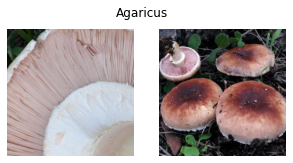

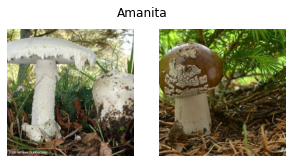

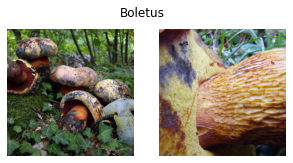

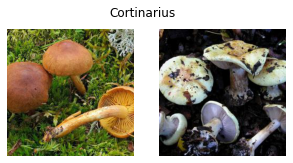

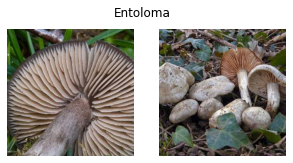

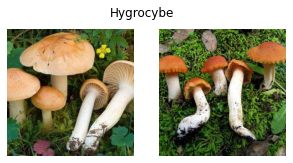

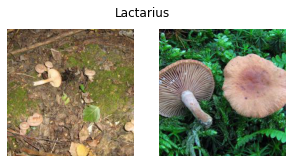

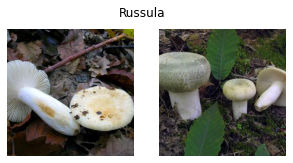

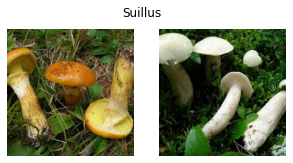

In [7]:
# plot the images selected
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
mean = torch.FloatTensor(mean).view(3,1,1)
std = torch.FloatTensor(std).view(3,1,1)

classes = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma',
           'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']

# Plot all example images
for c in range(len(test_images)):
  fig, plots = plt.subplots(1, len(test_images[0]), figsize=(5, 2.5))
  fig.suptitle(classes[c])

  for i in range(len(test_images[c])):
    img = test_images[c][i].squeeze(0) * std + mean
    plots[i].axis('off')
    plots[i].imshow(transforms.functional.to_pil_image(img))

In [9]:
# Find predictions through the model
predictions = []

for c in range(len(test_images)):
  predictions.append([])

  for img in test_images[c]:
    pred = F.softmax(fungi_net((img)), dim=1)
    #pred = F.softmax(fungi_net(img), dim=1)
    predictions[c].append(pred.squeeze(0))

In [10]:
# Display confidence of each class based on input image
for c in range(len(test_images)):
  for pred in predictions[c]:
    for conf in range(len(pred)):
      print(classes[conf] + ": {:.2f}%".format(pred[conf].item() * 100))
    print("Correct class:", classes[c])
    print('Most confident class:', classes[pred.max(0, keepdim=True)[1]],'\n')

Agaricus: 34.44%
Amanita: 18.84%
Boletus: 0.53%
Cortinarius: 0.77%
Entoloma: 15.55%
Hygrocybe: 0.93%
Lactarius: 21.49%
Russula: 7.29%
Suillus: 0.15%
Correct class: Agaricus
Most confident class: Agaricus 

Agaricus: 1.37%
Amanita: 0.70%
Boletus: 12.87%
Cortinarius: 8.65%
Entoloma: 0.56%
Hygrocybe: 0.31%
Lactarius: 61.86%
Russula: 7.36%
Suillus: 6.32%
Correct class: Agaricus
Most confident class: Lactarius 

Agaricus: 1.85%
Amanita: 45.14%
Boletus: 19.90%
Cortinarius: 8.66%
Entoloma: 6.35%
Hygrocybe: 0.33%
Lactarius: 12.20%
Russula: 4.06%
Suillus: 1.51%
Correct class: Amanita
Most confident class: Amanita 

Agaricus: 0.18%
Amanita: 1.56%
Boletus: 9.39%
Cortinarius: 29.74%
Entoloma: 8.82%
Hygrocybe: 7.08%
Lactarius: 38.58%
Russula: 3.44%
Suillus: 1.21%
Correct class: Amanita
Most confident class: Lactarius 

Agaricus: 0.55%
Amanita: 0.66%
Boletus: 22.94%
Cortinarius: 8.06%
Entoloma: 5.25%
Hygrocybe: 3.91%
Lactarius: 54.80%
Russula: 1.78%
Suillus: 2.05%
Correct class: Boletus
Most confide

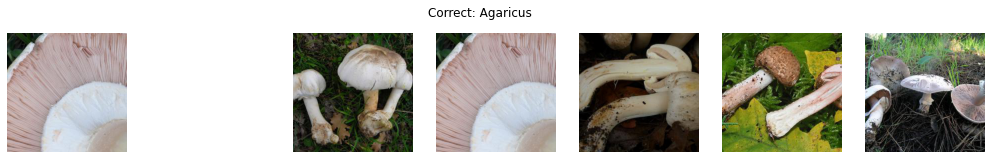

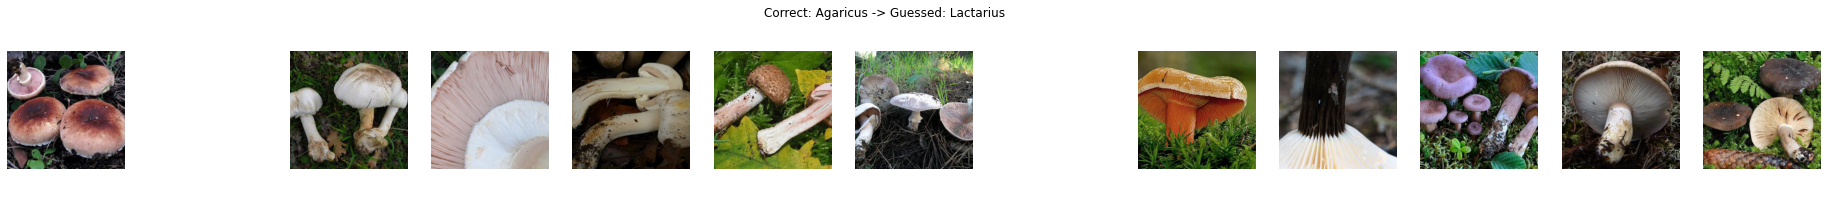

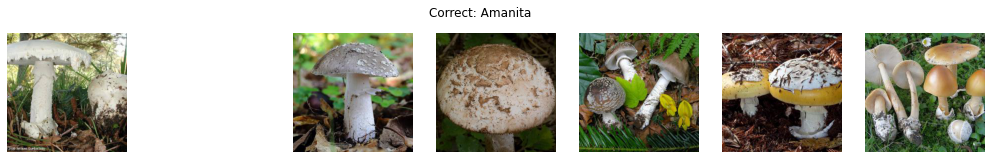

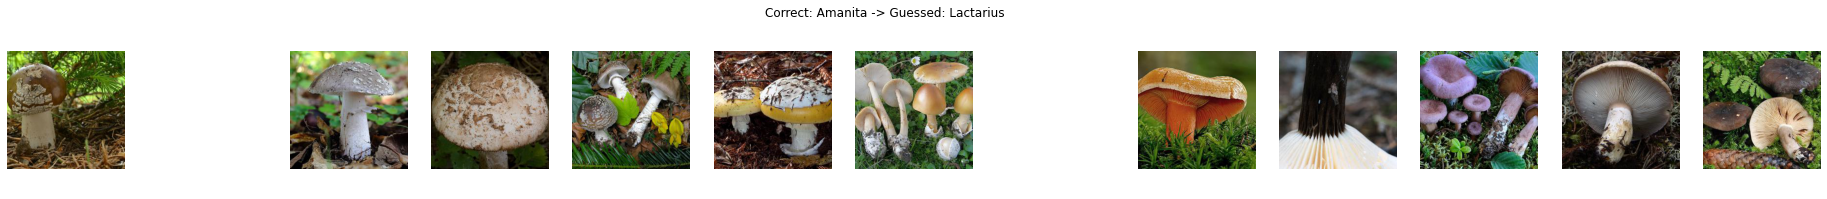

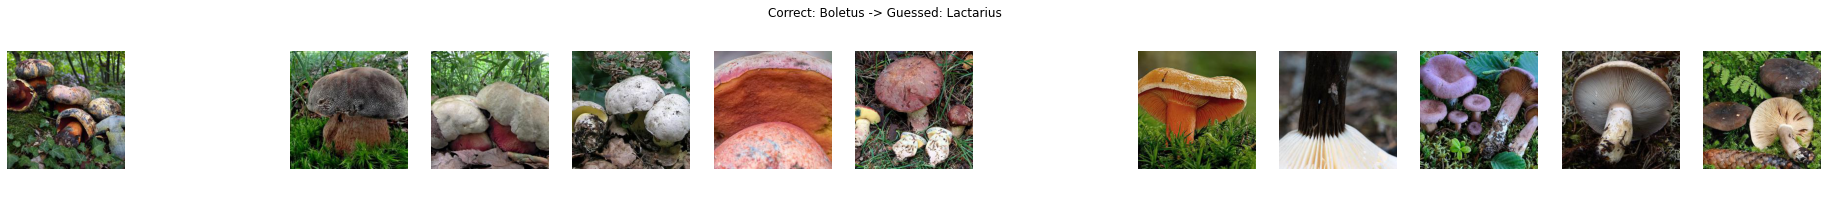

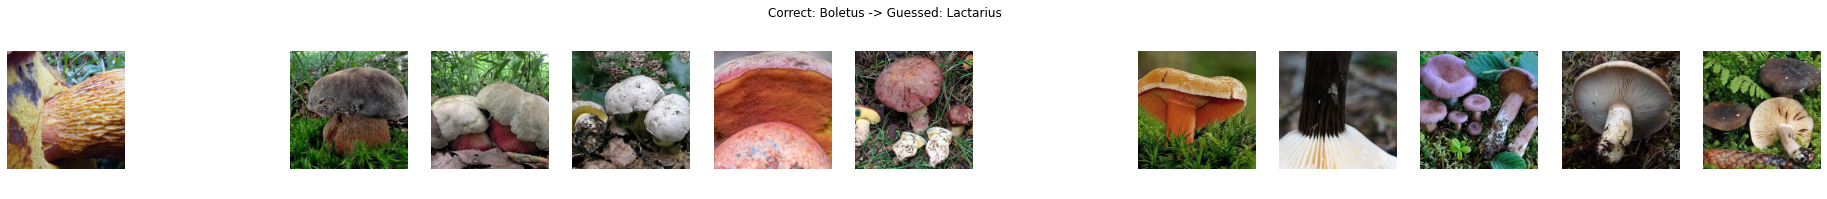

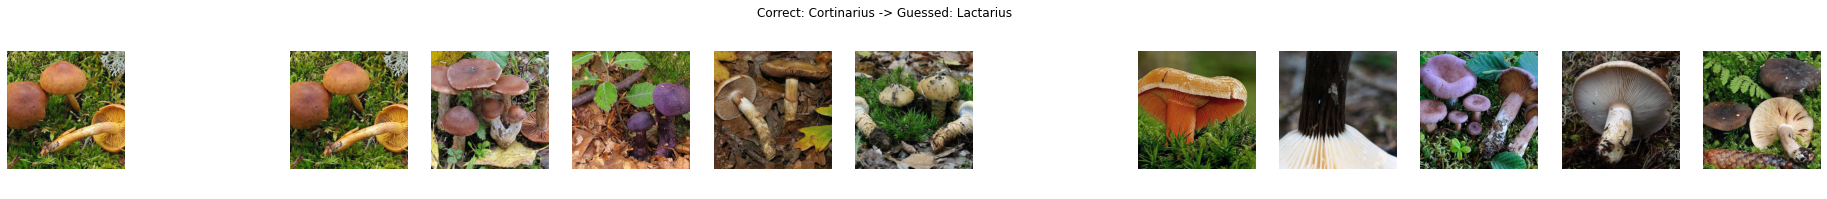

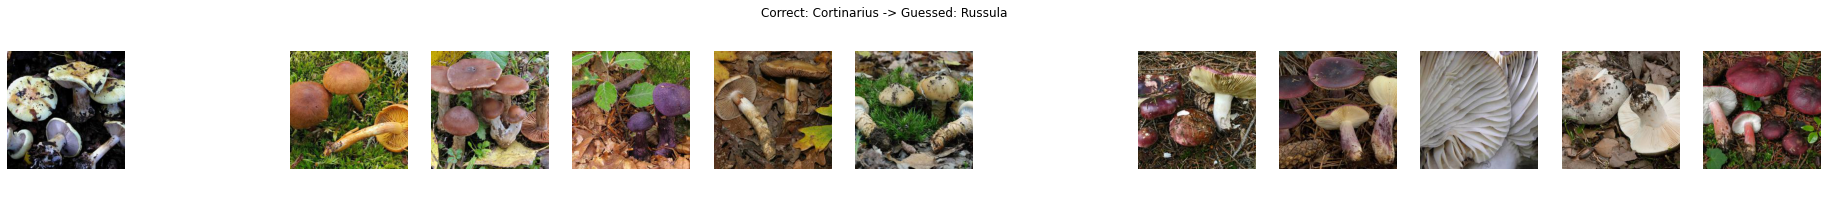

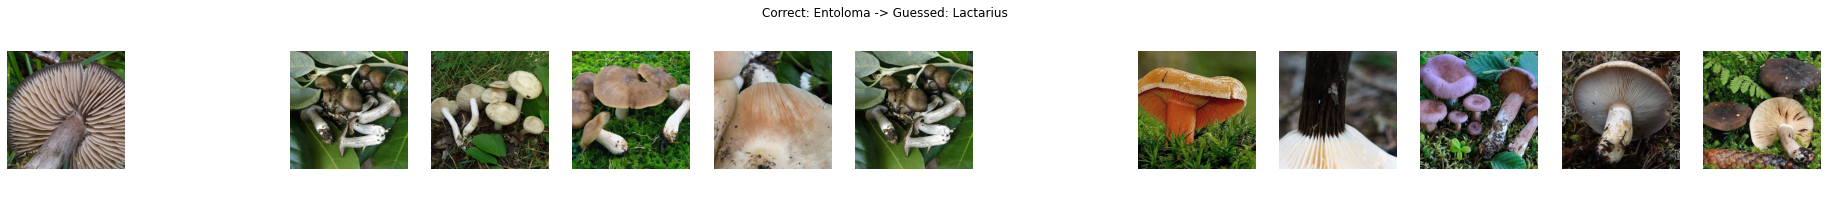

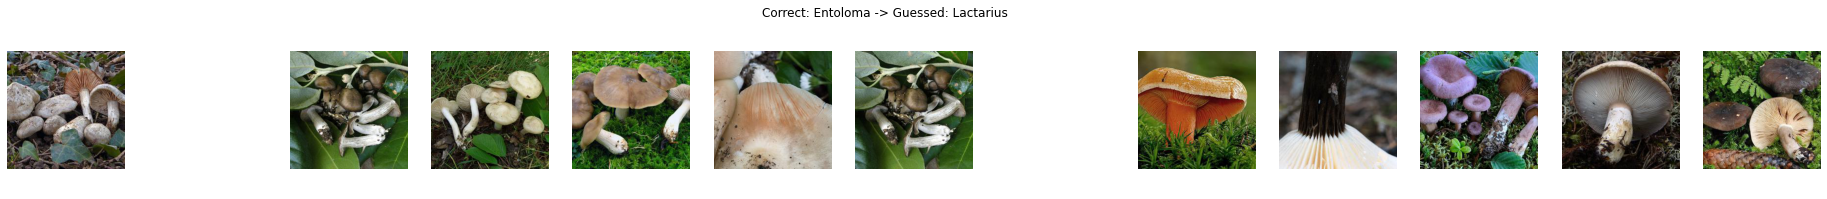

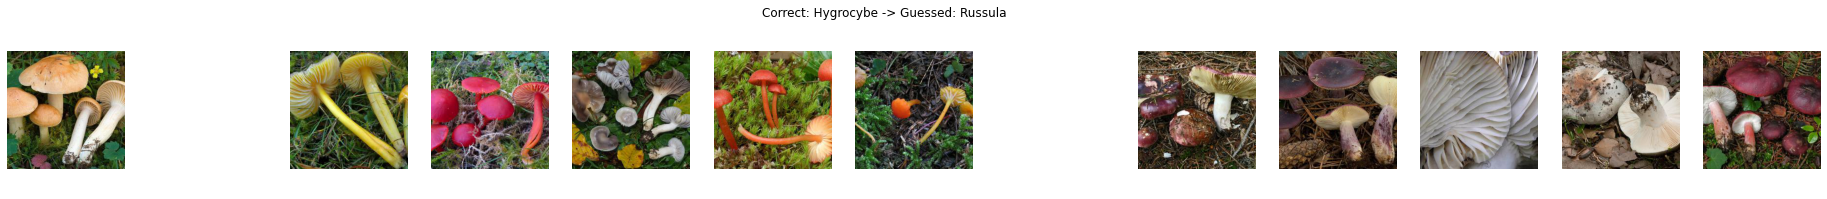

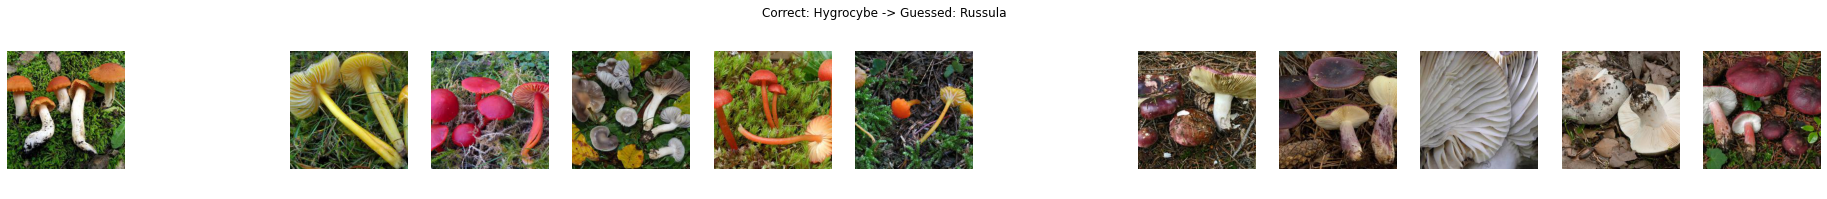

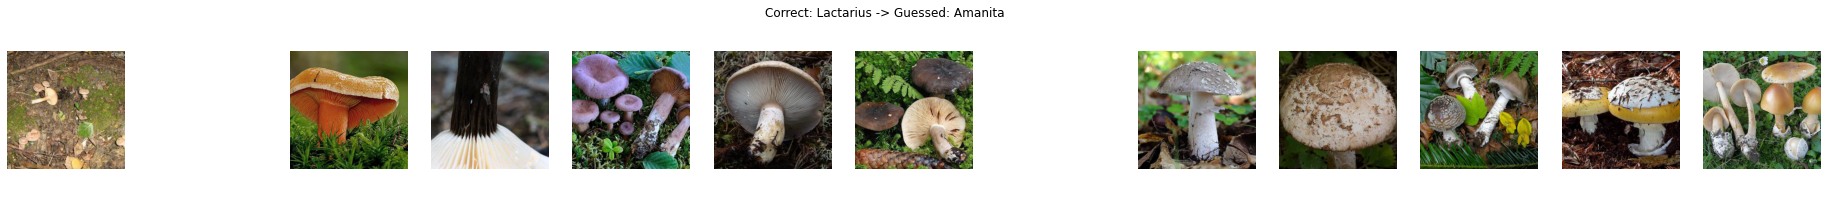

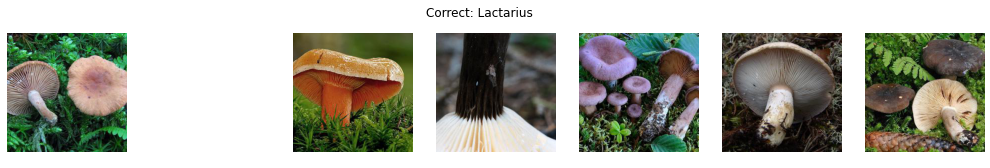

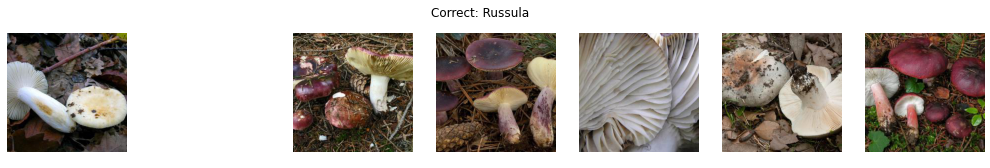

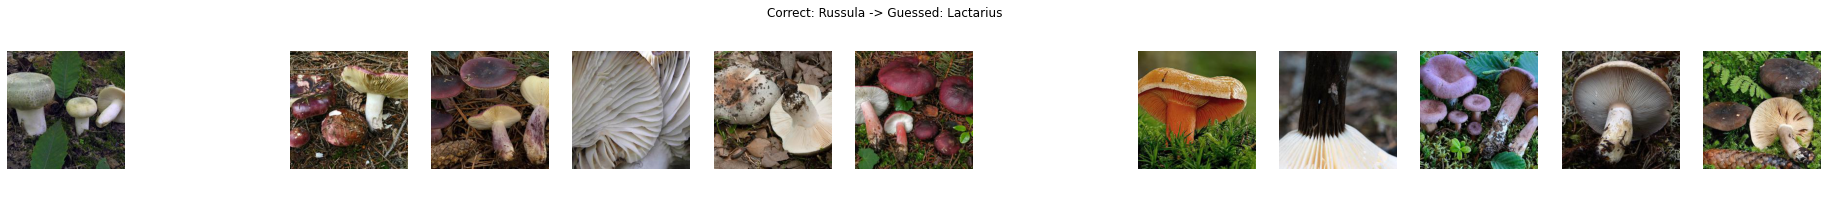

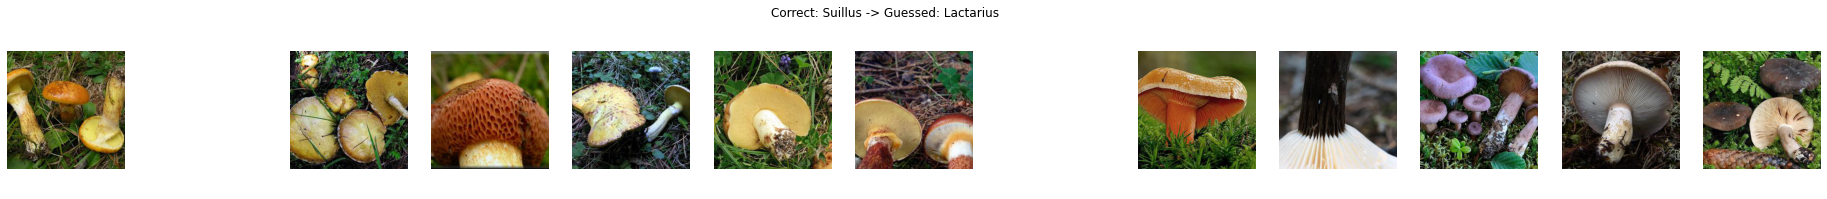

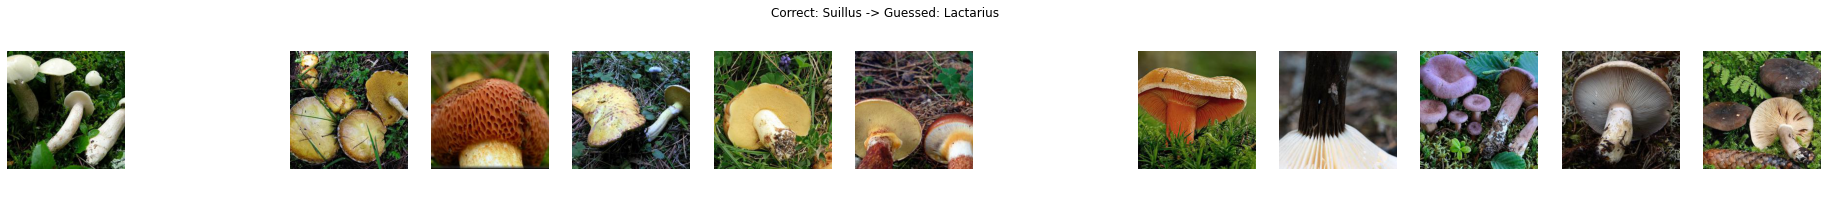

In [11]:
# Compare input image to examples from genus
#   Ex: 1 input image to 5 random examples

# grab example images to compare against
ex_images = []
for l in range(9):
  ex_images.append([])

  total_to_find = 5 # number of images left to find in this class
  while total_to_find > 0:
    img, label = next(iter(image_loader))

    if l == label:
      ex_images[l].append(img)
      total_to_find -= 1

# Plot the differences
for c in range(len(test_images)):
  for i in range(len(test_images[c])):
    guessed_class = predictions[c][i].max(0, keepdim=True)[1]
    
    if guessed_class != c:
      fig, plots = plt.subplots(1, 3 + 2 * len(ex_images[c]), figsize=(2.5 * (3 + 2 * len(ex_images[c])), 3))
      fig.suptitle('Correct: ' + classes[c] + ' -> Guessed: ' + classes[guessed_class])
    else:
      fig, plots = plt.subplots(1, 2 + len(ex_images[c]), figsize=(2.5 * (2 + len(ex_images[c])), 2.5))
      fig.suptitle('Correct: ' + classes[c])

    img = test_images[c][i].squeeze(0) * std + mean
    plots[0].axis('off')
    plots[0].imshow(transforms.functional.to_pil_image(img))

    plots[1].axis('off')

    # print correct class
    for g_im in range(len(ex_images[c])):
      img = ex_images[c][g_im].squeeze(0) * std + mean
      plots[g_im + 2].axis('off')
      plots[g_im + 2].imshow(transforms.functional.to_pil_image(img))

    if guessed_class != c:
      plots[2 + len(ex_images[c])].axis('off')

      # print guessed class
      for g_im in range(len(ex_images[c])):
        img = ex_images[guessed_class][g_im].squeeze(0) * std + mean
        plots[g_im + 3 + len(ex_images[c])].axis('off')
        plots[g_im + 3 + len(ex_images[c])].imshow(transforms.functional.to_pil_image(img))